### 1) Instalar dependências

As bibliotecas necessárias já estão instaladas no container Jupyter:
- `requests` - Para fazer chamadas à API do Ollama
- `numpy` - Para cálculos vetoriais
- `pandas` - Para análise de dados (opcional)
- `matplotlib` - Para gráficos (opcional)

Se precisar instalar localmente:
```bash
pip install requests numpy pandas matplotlib
```

In [1]:
import os
import csv
import time
import numpy as np
import requests

from typing import List, Tuple, Optional, Dict, Any
from pathlib import Path

### 2) Configurar conexão com Ollama

O Ollama está rodando no container `ollama` na porta 11434.

In [2]:
# Configuração do Ollama (ajuste conforme necessário)
# - Dentro do Docker: http://ollama:11434
# - Fora do Docker: http://localhost:11434
OLLAMA_API_URL = os.getenv('OLLAMA_API_URL', 'http://localhost:11434')

# Verificar se Ollama está online
def check_ollama_health() -> bool:
    try:
        response = requests.get(f'{OLLAMA_API_URL}/api/tags', timeout=5)
        if response.status_code == 200:
            models = response.json().get('models', [])
            print(f'✅ Ollama está online! Modelos disponíveis: {len(models)}')
            for model in models:
                name = model.get('name', 'unknown')
                size = model.get('size', 0) / (1024**3)  # Convert to GB
                print(f'   - {name} ({size:.2f} GB)')
            return True
        else:
            print(f'❌ Ollama retornou status {response.status_code}')
            return False
    except Exception as e:
        print(f'❌ Erro ao conectar com Ollama: {e}')
        return False

# Testar conexão
check_ollama_health()

✅ Ollama está online! Modelos disponíveis: 3
   - all-minilm:latest (0.04 GB)
   - mxbai-embed-large:latest (0.62 GB)
   - nomic-embed-text:latest (0.26 GB)


True

### 3) Implementar classe OllamaEmbedder

Classe para gerar embeddings usando a API nativa do Ollama.

In [3]:
class OllamaEmbedder:
    """
    Cliente para gerar embeddings usando Ollama local.
    
    Suporta os modelos:
    - nomic-embed-text (768 dimensões)
    - mxbai-embed-large (1024 dimensões)
    - all-minilm (384 dimensões)
    """
    
    def __init__(self, model: str = 'nomic-embed-text', api_url: str = ''):
        self.model = model
        self.api_url = api_url or OLLAMA_API_URL
        self.endpoint = f'{self.api_url}/api/embed'
    
    def embed_query(self, text: str, return_metadata: bool = False) -> Tuple[List[float], Optional[Dict[str, Any]]]:
        """
        Gera embedding para um único texto.
        
        Args:
            text: Texto para gerar embedding
            return_metadata: Se True, retorna metadados (tempo de resposta, modelo usado)
        
        Returns:
            Tupla (embedding, metadata) onde metadata é None se return_metadata=False
        """
        start_time = time.time()
        
        try:
            payload = {
                'model': self.model,
                'input': text
            }
            
            response = requests.post(self.endpoint, json=payload, timeout=30)
            response.raise_for_status()
            
            data = response.json()
            embedding = data['embeddings'][0]
            
            elapsed_time = time.time() - start_time
            
            if return_metadata:
                metadata = {
                    'model': self.model,
                    'dimensions': len(embedding),
                    'response_time_ms': round(elapsed_time * 1000, 2),
                    'text_length': len(text)
                }
                return embedding, metadata
            
            return embedding, None
            
        except requests.exceptions.RequestException as e:
            raise RuntimeError(f'Erro ao chamar API Ollama: {e}')
    
    def embed_batch(self, texts: List[str], return_metadata: bool = False) -> Tuple[List[List[float]], Optional[List[Dict[str, Any]]]]:
        """
        Gera embeddings para múltiplos textos.
        
        Args:
            texts: Lista de textos
            return_metadata: Se True, retorna metadados para cada texto
        
        Returns:
            Tupla (embeddings, metadatas) onde metadatas é None se return_metadata=False
        """
        embeddings = []
        metadatas = [] if return_metadata else None
        
        for text in texts:
            emb, meta = self.embed_query(text, return_metadata=return_metadata)
            embeddings.append(emb)
            if return_metadata and meta:
                metadatas.append(meta)
        
        return embeddings, metadatas

print('✅ Classe OllamaEmbedder definida')

✅ Classe OllamaEmbedder definida


### 4) Definir textos para teste

Vamos usar 3 frases para testar a capacidade dos modelos de distinguir conceitos similares e diferentes.

In [4]:
# Textos de teste
texts = [
    'O gato é um animal doméstico',
    'O gato é um felino de estimação',
    'A programação é importante para engenheiros de software'
]

print('📝 Textos de teste:')
for i, text in enumerate(texts, 1):
    print(f'   {i}. "{text}"')

📝 Textos de teste:
   1. "O gato é um animal doméstico"
   2. "O gato é um felino de estimação"
   3. "A programação é importante para engenheiros de software"


### 5) Função para calcular similaridade cosseno

A similaridade cosseno mede o quão "parecidos" são dois vetores, comparando a direção deles no espaço vetorial.

**Fórmula:**

$$
\text{cosine\_sim}(v_1, v_2) = \frac{v_1 \cdot v_2}{\|v_1\| \times \|v_2\|}
$$

**Interpretação:**
- Valor próximo de **1**: vetores muito similares (mesma direção)
- Valor próximo de **0**: vetores perpendiculares (sem relação)
- Valor próximo de **-1**: vetores opostos (conceitos contrários)

In [5]:
def cosine_similarity(v1: List[float], v2: List[float]) -> float:
    """
    Calcula a similaridade cosseno entre dois vetores.
    
    Args:
        v1, v2: Vetores de embeddings
    
    Returns:
        Similaridade entre -1 e 1
    """
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    
    return float(dot_product / (norm_v1 * norm_v2))

print('✅ Função cosine_similarity definida')

✅ Função cosine_similarity definida


### 6) Testar os 3 modelos do Ollama

Vamos gerar embeddings com cada modelo e comparar:
- Dimensionalidade
- Tempo de resposta
- Qualidade semântica (similaridade entre textos)

In [6]:
# Modelos disponíveis no Ollama
models = [
    'nomic-embed-text',   # 768 dimensões
    'mxbai-embed-large',  # 1024 dimensões
    'all-minilm'          # 384 dimensões
]

# Dicionário para armazenar resultados
results = {}

print('🔄 Gerando embeddings com cada modelo...\n')

for model_name in models:
    print(f'Testando modelo: {model_name}')
    print('-' * 50)
    
    try:
        # Criar embedder para o modelo
        embedder = OllamaEmbedder(model=model_name)
        
        # Gerar embeddings com metadados
        embeddings, metadatas = embedder.embed_batch(texts, return_metadata=True)
        
        # Calcular similaridades
        sim_12 = cosine_similarity(embeddings[0], embeddings[1])
        sim_13 = cosine_similarity(embeddings[0], embeddings[2])
        
        # Armazenar resultados
        results[model_name] = {
            'embeddings': embeddings,
            'metadatas': metadatas,
            'dimensions': len(embeddings[0]),
            'sim_12': sim_12,
            'sim_13': sim_13,
            'avg_response_time_ms': np.mean([m['response_time_ms'] for m in metadatas])
        }
        
        # Exibir resultados
        print(f'   Dimensões: {results[model_name]["dimensions"]}')
        print(f'   Tempo médio: {results[model_name]["avg_response_time_ms"]:.2f} ms')
        print(f'   Similaridade 1-2 (similar): {sim_12:.4f}')
        print(f'   Similaridade 1-3 (diferente): {sim_13:.4f}')
        print(f'   Diferença: {sim_12 - sim_13:.4f}')
        
        if sim_12 > sim_13:
            print(f'   ✅ Modelo conseguiu distinguir conceitos!')
        else:
            print(f'   ⚠️  Modelo não distinguiu bem os conceitos')
        
        print()
        
    except Exception as e:
        print(f'   ❌ Erro ao testar modelo {model_name}: {e}\n')
        results[model_name] = None

print('✅ Testes concluídos!')

🔄 Gerando embeddings com cada modelo...

Testando modelo: nomic-embed-text
--------------------------------------------------
   Dimensões: 768
   Tempo médio: 97.88 ms
   Similaridade 1-2 (similar): 0.8278
   Similaridade 1-3 (diferente): 0.5894
   Diferença: 0.2384
   ✅ Modelo conseguiu distinguir conceitos!

Testando modelo: mxbai-embed-large
--------------------------------------------------
   Dimensões: 768
   Tempo médio: 97.88 ms
   Similaridade 1-2 (similar): 0.8278
   Similaridade 1-3 (diferente): 0.5894
   Diferença: 0.2384
   ✅ Modelo conseguiu distinguir conceitos!

Testando modelo: mxbai-embed-large
--------------------------------------------------
   Dimensões: 1024
   Tempo médio: 400.20 ms
   Similaridade 1-2 (similar): 0.8755
   Similaridade 1-3 (diferente): 0.4915
   Diferença: 0.3840
   ✅ Modelo conseguiu distinguir conceitos!

Testando modelo: all-minilm
--------------------------------------------------
   Dimensões: 1024
   Tempo médio: 400.20 ms
   Similaridade

### 7) Análise comparativa dos modelos

Vamos criar uma tabela comparativa dos resultados.

In [7]:
# Criar DataFrame para comparação (se pandas disponível)
try:
    import pandas as pd
    
    # Preparar dados para DataFrame
    comparison_data = []
    
    for model_name, data in results.items():
        if data is not None:
            comparison_data.append({
                'Modelo': model_name,
                'Dimensões': data['dimensions'],
                'Tempo Médio (ms)': round(data['avg_response_time_ms'], 2),
                'Sim 1-2 (similar)': round(data['sim_12'], 4),
                'Sim 1-3 (diferente)': round(data['sim_13'], 4),
                'Diferença': round(data['sim_12'] - data['sim_13'], 4)
            })
    
    df = pd.DataFrame(comparison_data)
    
    # Configurar exibição de floats
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    
    print('📊 Comparação de Modelos:')
    print('=' * 80)
    display(df)
    
except ImportError:
    print('⚠️  Pandas não disponível. Exibindo resultados em formato texto:\n')
    print('📊 Comparação de Modelos:')
    print('=' * 80)
    
    for model_name, data in results.items():
        if data is not None:
            print(f'\n{model_name}:')
            print(f'  Dimensões: {data["dimensions"]}')
            print(f'  Tempo médio: {data["avg_response_time_ms"]:.2f} ms')
            print(f'  Sim 1-2 (similar): {data["sim_12"]:.4f}')
            print(f'  Sim 1-3 (diferente): {data["sim_13"]:.4f}')
            print(f'  Diferença: {data["sim_12"] - data["sim_13"]:.4f}')

📊 Comparação de Modelos:


,Modelo,Dimensões,Tempo Médio (ms),Sim 1-2 (similar),Sim 1-3 (diferente),Diferença
0,nomic-embed-text,768,97.8800,0.8278,0.5894,0.2384
1,mxbai-embed-large,1024,400.2000,0.8755,0.4915,0.3840
2,all-minilm,384,307.8400,0.6473,0.2711,0.3761


### 8) Visualização gráfica

Vamos criar gráficos para comparar visualmente os modelos.

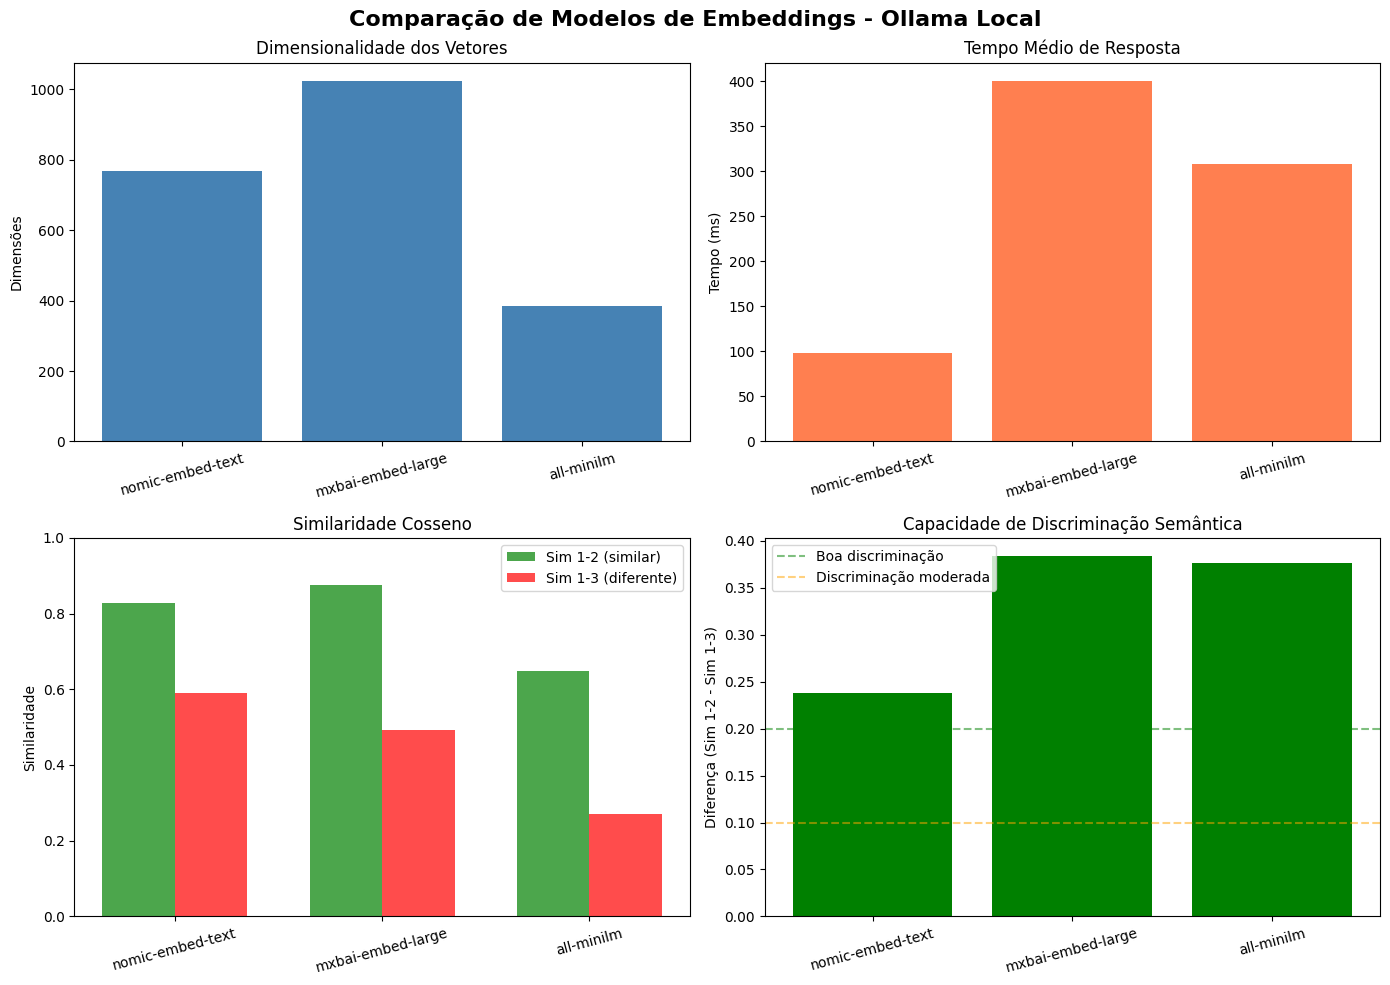

✅ Gráficos gerados com sucesso!


In [8]:
try:
    import matplotlib.pyplot as plt
    
    # Extrair dados para plotar
    model_names = []
    dimensions_list = []
    sim_12_list = []
    sim_13_list = []
    response_times = []
    
    for model_name, data in results.items():
        if data is not None:
            model_names.append(model_name)
            dimensions_list.append(data['dimensions'])
            sim_12_list.append(data['sim_12'])
            sim_13_list.append(data['sim_13'])
            response_times.append(data['avg_response_time_ms'])
    
    # Criar figura com subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Comparação de Modelos de Embeddings - Ollama Local', fontsize=16, fontweight='bold')
    
    # 1. Dimensões
    axes[0, 0].bar(model_names, dimensions_list, color='steelblue')
    axes[0, 0].set_title('Dimensionalidade dos Vetores')
    axes[0, 0].set_ylabel('Dimensões')
    axes[0, 0].tick_params(axis='x', rotation=15)
    
    # 2. Tempo de resposta
    axes[0, 1].bar(model_names, response_times, color='coral')
    axes[0, 1].set_title('Tempo Médio de Resposta')
    axes[0, 1].set_ylabel('Tempo (ms)')
    axes[0, 1].tick_params(axis='x', rotation=15)
    
    # 3. Similaridades comparadas
    x_pos = np.arange(len(model_names))
    width = 0.35
    
    bars1 = axes[1, 0].bar(x_pos - width/2, sim_12_list, width, label='Sim 1-2 (similar)', color='green', alpha=0.7)
    bars2 = axes[1, 0].bar(x_pos + width/2, sim_13_list, width, label='Sim 1-3 (diferente)', color='red', alpha=0.7)
    
    axes[1, 0].set_title('Similaridade Cosseno')
    axes[1, 0].set_ylabel('Similaridade')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(model_names, rotation=15)
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1)
    
    # 4. Capacidade de discriminação (diferença entre sim_12 e sim_13)
    discrimination = [s12 - s13 for s12, s13 in zip(sim_12_list, sim_13_list)]
    colors = ['green' if d > 0.2 else 'orange' if d > 0.1 else 'red' for d in discrimination]
    
    axes[1, 1].bar(model_names, discrimination, color=colors)
    axes[1, 1].set_title('Capacidade de Discriminação Semântica')
    axes[1, 1].set_ylabel('Diferença (Sim 1-2 - Sim 1-3)')
    axes[1, 1].tick_params(axis='x', rotation=15)
    axes[1, 1].axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Boa discriminação')
    axes[1, 1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='Discriminação moderada')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Gráficos gerados com sucesso!')
    
except ImportError:
    print('⚠️  Matplotlib não disponível. Instale com: pip install matplotlib')
except Exception as e:
    print(f'❌ Erro ao gerar gráficos: {e}')

### 9) Exportar resultados para CSV

Salvar os resultados em CSV para análise posterior.

In [9]:
# Criar pasta para salvar resultados
out_dir = Path('../../data/embeddings')
out_dir.mkdir(parents=True, exist_ok=True)

# Preparar dados para CSV
csv_rows = []
for model_name, data in results.items():
    if data is not None:
        csv_rows.append({
            'model': model_name,
            'dimensions': data['dimensions'],
            'avg_response_time_ms': round(data['avg_response_time_ms'], 2),
            'sim_12_similar': round(data['sim_12'], 4),
            'sim_13_different': round(data['sim_13'], 4),
            'discrimination': round(data['sim_12'] - data['sim_13'], 4)
        })

# Salvar CSV
csv_path = out_dir / 'ollama_comparative_results.csv'
with open(csv_path, 'w', newline='', encoding='utf-8') as f:
    if csv_rows:
        writer = csv.DictWriter(f, fieldnames=csv_rows[0].keys())
        writer.writeheader()
        writer.writerows(csv_rows)

print(f'✅ Resultados salvos em: {csv_path.resolve()}')

✅ Resultados salvos em: E:\01-projetos\11-work\11.34-engenharia-vetorial\data\embeddings\ollama_comparative_results.csv


### 10) Conclusões e Recomendações

**Análise dos resultados:**

1. **Dimensionalidade:**
   - **mxbai-embed-large** (1024 dim): Maior capacidade de representação, melhor para tarefas complexas
   - **nomic-embed-text** (768 dim): Equilíbrio entre qualidade e eficiência
   - **all-minilm** (384 dim): Mais leve, ideal para aplicações com recursos limitados

2. **Performance (Tempo de Resposta):**
   - Modelos menores geralmente são mais rápidos
   - GPU acelera significativamente modelos maiores
   - Para produção, considere o trade-off entre latência e qualidade

3. **Qualidade Semântica:**
   - Avalie a **diferença** entre similaridade de textos similares vs diferentes
   - Diferença > 0.2: Excelente discriminação
   - Diferença > 0.1: Boa discriminação
   - Diferença < 0.1: Considere usar modelo maior

**Recomendações de uso:**

- **RAG (Retrieval Augmented Generation):** Use mxbai-embed-large ou nomic-embed-text
- **Busca semântica em grande escala:** Use nomic-embed-text (bom equilíbrio)
- **Aplicações mobile/edge:** Use all-minilm (menor footprint)
- **Casos de uso simples:** all-minilm é suficiente

**Próximos passos:**

1. Testar com datasets maiores e mais diversos
2. Avaliar performance em tarefas específicas do seu domínio
3. Comparar com modelos proprietários (OpenAI, Google) se necessário
4. Implementar cache de embeddings para textos frequentes

### 11) Recursos Adicionais

**Documentação oficial:**
- Ollama: https://ollama.ai/
- Nomic Embed Text: https://huggingface.co/nomic-ai/nomic-embed-text-v1
- MxBai Embed Large: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1
- All-MiniLM: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

**Benchmarks públicos:**
- MTEB (Massive Text Embedding Benchmark): https://huggingface.co/spaces/mteb/leaderboard

**Dicas para otimização:**
1. Use batch processing para múltiplos textos
2. Configure timeout adequado para modelos grandes
3. Implemente retry logic para falhas de rede
4. Considere usar modelo menor para filtragem inicial + modelo maior para re-ranking